In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/home/victor/catkin_ws/src/ai4hri/simulated data.csv")

costumer = df.iloc[:,14]
costumer_clean = costumer.dropna()

shopkeeper = df.iloc[:,16]
shopkeeper_clean = shopkeeper.dropna()

costumer_list = costumer_clean.values.tolist()
shopkeeper_list = shopkeeper_clean.values.tolist()

print(shopkeeper_clean)
print(len(shopkeeper_list))

1                       good afternoon how can I help today
2         Yes we do have this nikon camera it's a point ...
3         This camera is very easy to use. Just choose a...
4         Because it's fully automatic sometimes gets a ...
5                thanks for your time have a good afternoon
                                ...                        
124170             can I ask what sort of pictures you take
124171    let me explain the layout of the store, the ni...
124172    it also has 18 different modes where you can t...
124173    this camera comes in purple pink black silver ...
124174                                      Thanks for time
Name: SHOPKEEPER_SPEECH, Length: 95430, dtype: object
95430


In [3]:
import openai
import os

openai.organization = os.environ['OPENAI_ORG_ID']
openai.api_key = os.environ["OPENAI_API_KEY"]

model = "text-embedding-ada-002"

iterations = (int(len(shopkeeper_list)/1000))

list=[]

for i in range(10):

    print(1000*i,1000*(i+1))
    res = openai.Embedding.create( input = shopkeeper_list[(1000*i):(1000*(i+1))], engine=model)

    for vec in res["data"]:
        list.append(vec["embedding"])

arr = np.asarray(list)
np.save("arr.npy", arr)
print(arr.shape)

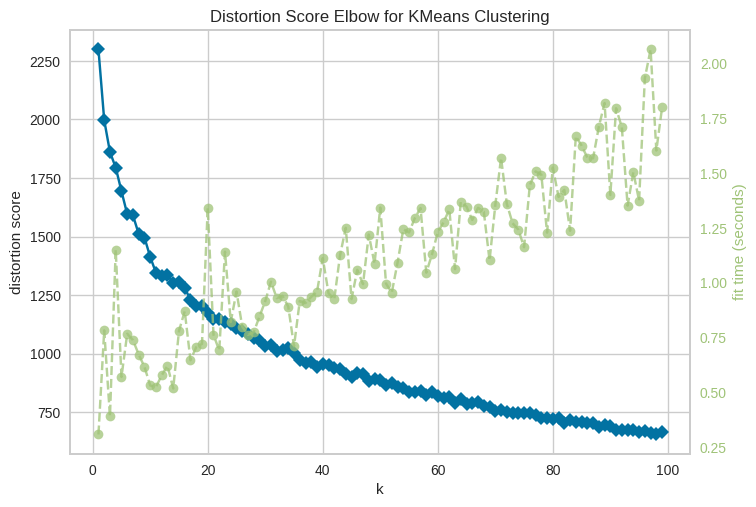

In [3]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

arr = np.load('/home/victor/catkin_ws/src/arr.npy',allow_pickle='TRUE')

model = KMeans(n_init="auto")
visualizer = KElbowVisualizer(model, k=(1,100), locate_elbow=False)

visualizer.fit(arr)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [9]:
n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans.fit(arr)
np.save("kmeans_model.npy", kmeans)
y = kmeans.predict(arr)

print(y)

[  1  79  14 ...   9  74 178]


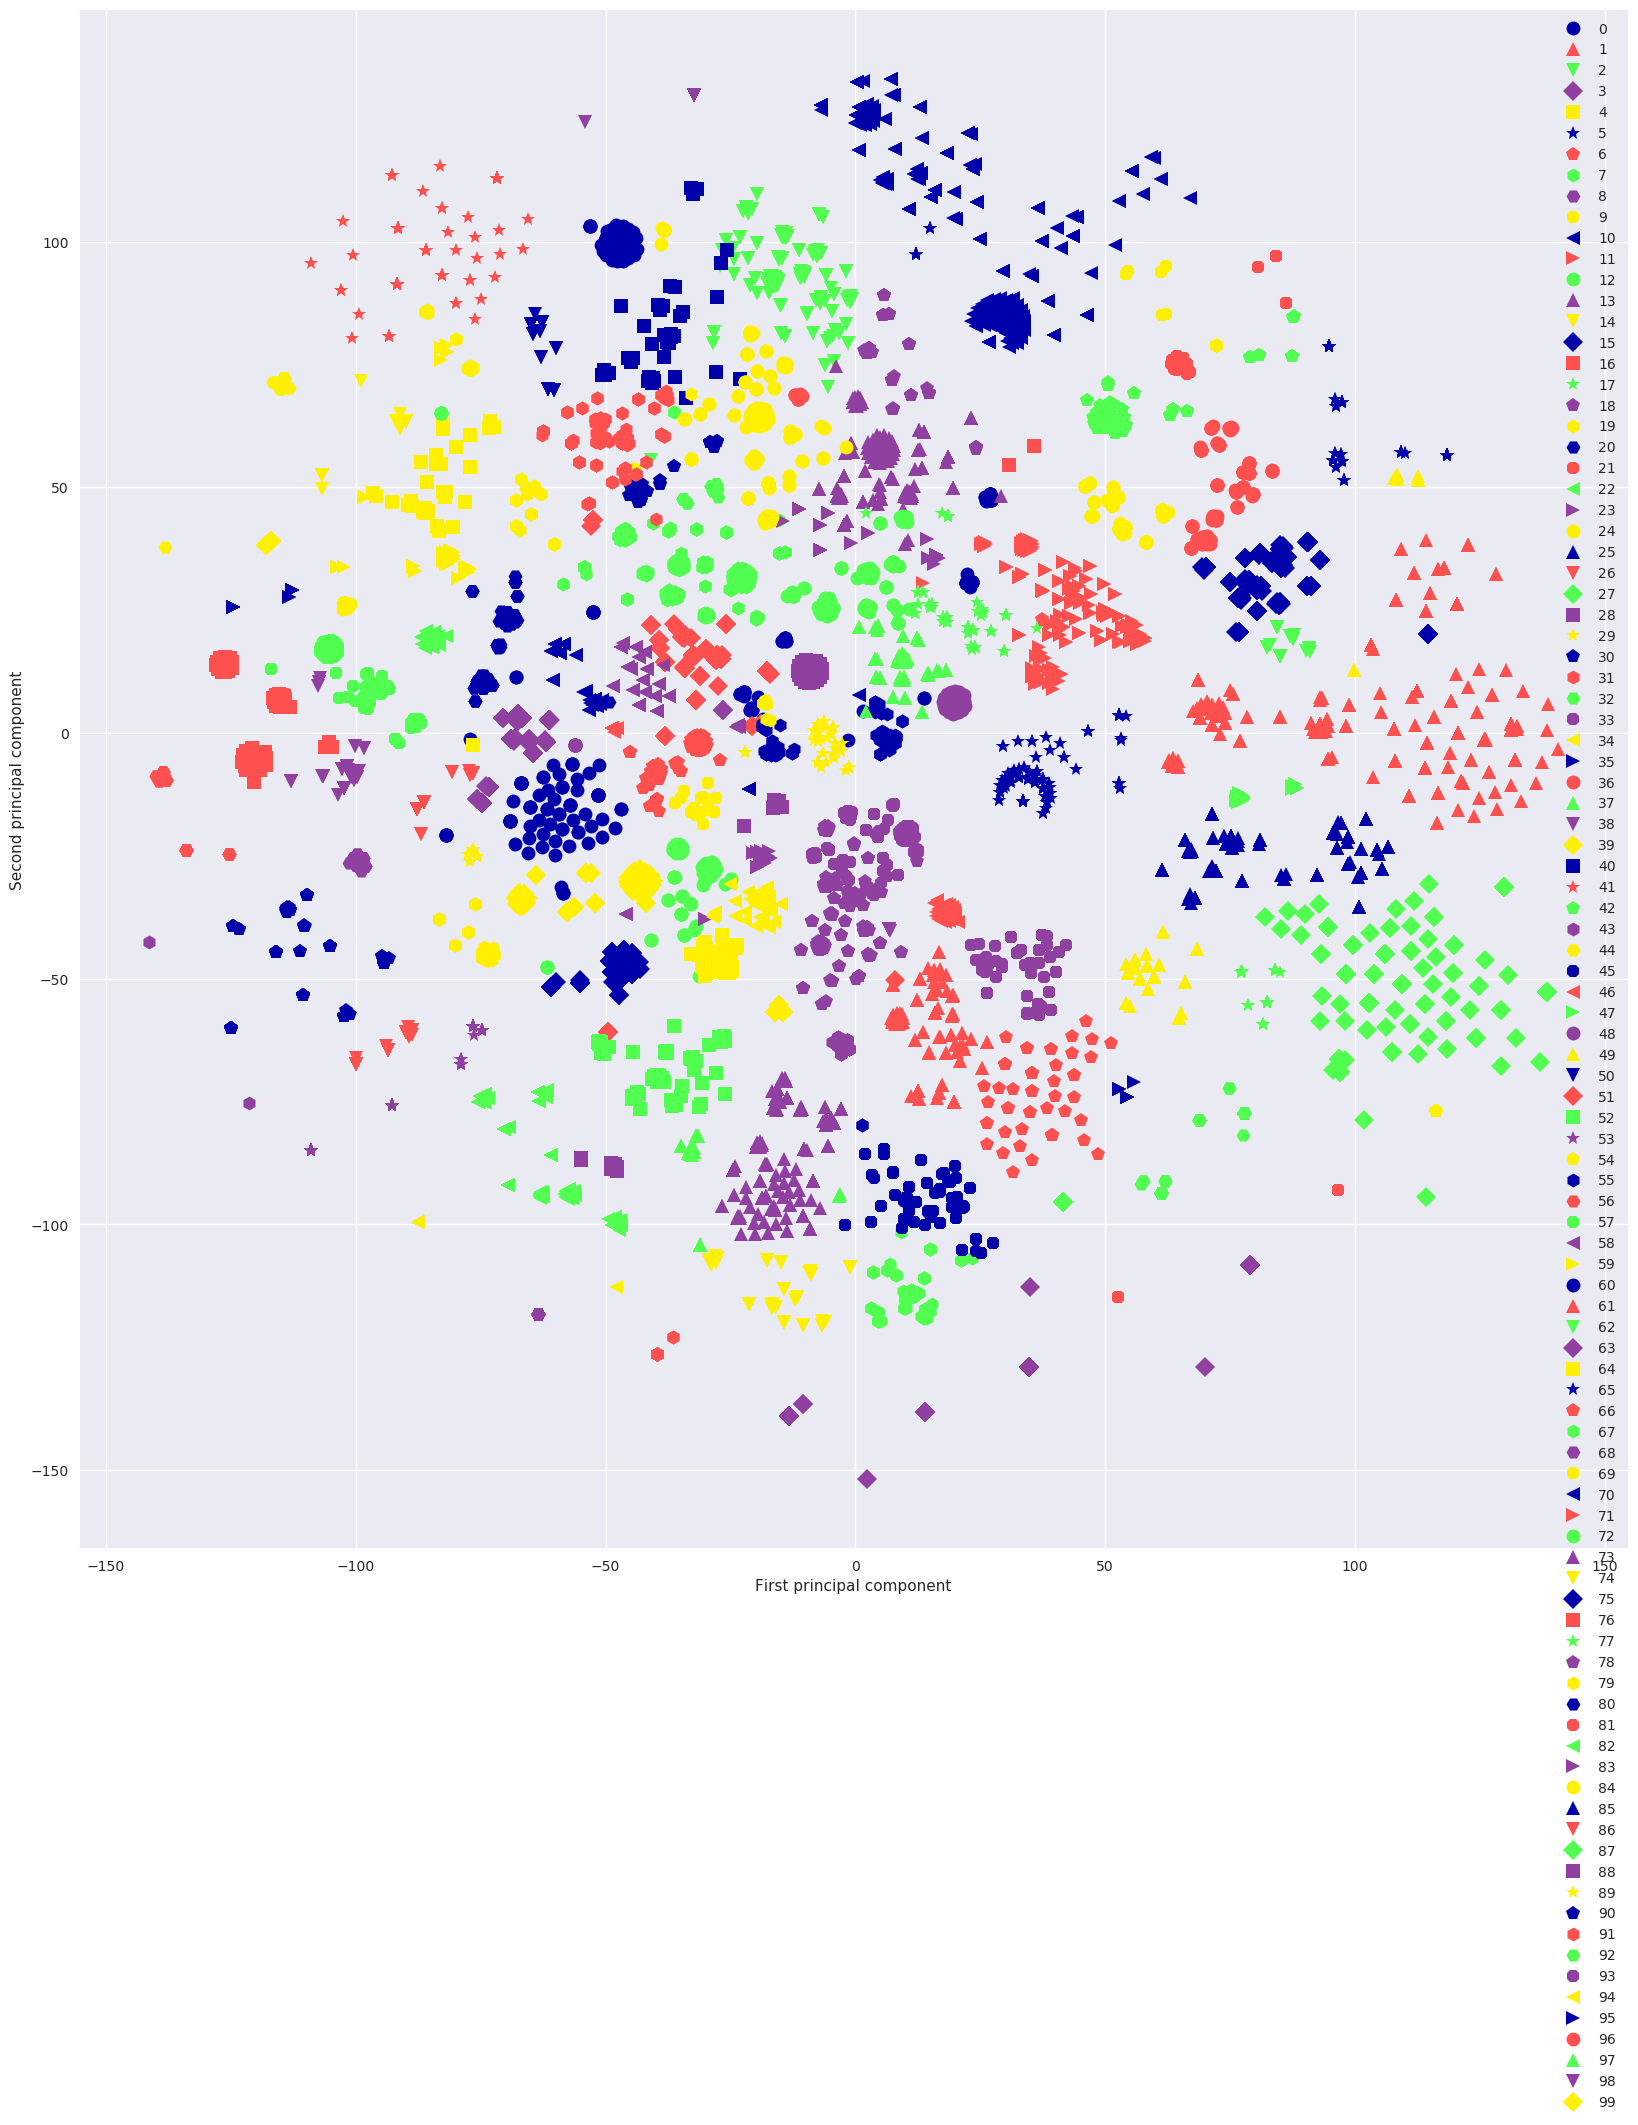

In [8]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import plot_scatter as ps

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(arr)

n_classes=np.arange(0, 100, 1).tolist()
s = []
for x in n_classes:
    s.append(str(x))

plt.figure(figsize=(20, 20))
sns.set_style('darkgrid')
ps.discrete_scatter(tsne_result[:, 0], tsne_result[:, 1], y)
plt.legend(s, loc="best")
#plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()





In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

cluster_X = np.where(y == 17)[0]

vector_list = []
for j in cluster_X:
    print(shopkeeper_list[j])
    print(arr[j])
    vector_list.append(arr[j].tolist())
    print("----------------------")

print("Cosine similarity between a given utterance and the rest of the cluster:")
cluster_sum_list = []
for i in range(len(vector_list)):
    total_sum=0
    for j in range(len(vector_list)):
        total_sum += cosine_similarity([vector_list[i]],[vector_list[j]])
    cluster_sum_list.append(total_sum)
    print(cluster_sum_list[i])

print("----------------------")
cluster_sum_array = np.array(cluster_sum_list)
typical_utt = shopkeeper_list[cluster_X[np.argmax(cluster_sum_list)]]
print("Typical utterance inside the cluster: " + typical_utt)

kw_model = KeyBERT(model='all-mpnet-base-v2')
keywords = kw_model.extract_keywords(typical_utt, keyphrase_ngram_range=(1,1), use_maxsum=False, top_n=10)

print("Assigned keywords to the utterance: " + str(keywords))





/home/victor/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


this one he's excellent it takes pictures that are as good as a top-end professional model but it's a quarter of the price
[-0.00945365  0.04029212  0.00466163 ... -0.01092712 -0.00677403
 -0.01426524]
----------------------
the photos from this are almost as good as a top end fashion photography camera
[ 4.23894417e-05  2.09639482e-02 -4.25505871e-03 ...  8.77605844e-03
  7.31013902e-03 -1.95758641e-02]
----------------------
the photos from this are almost as good as a top end fashion photography camera
[ 4.23894417e-05  2.09639482e-02 -4.25505871e-03 ...  8.77605844e-03
  7.31013902e-03 -1.95758641e-02]
----------------------
this one he's excellent it takes pictures that are as good as a top-end professional model but it's a quarter of the price
[-0.00945365  0.04029212  0.00466163 ... -0.01092712 -0.00677403
 -0.01426524]
----------------------
the Minolta is more like the Sony camera, we have over here, it's a quarter the price includes the lens and still takes absolutely beautif

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

keyword_dict = {}
utterance_dict = {}

for z in range(n_clusters):
    cluster_X = np.where(y == z)[0]
    vector_list = []
    for j in cluster_X:
        vector_list.append(arr[j].tolist())

    cluster_sum_list = []
    for i in range(len(vector_list)):
        total_sum=0
        for j in range(len(vector_list)):
            total_sum += cosine_similarity([vector_list[i]],[vector_list[j]])
        cluster_sum_list.append(total_sum)

    cluster_sum_array = np.array(cluster_sum_list)
    typical_utt = shopkeeper_list[cluster_X[np.argmax(cluster_sum_list)]]
    print("Cluster " + str(z) + ": " + typical_utt)

    kw_model = KeyBERT(model='all-mpnet-base-v2')
    keywords = kw_model.extract_keywords(typical_utt, keyphrase_ngram_range=(1,1), use_maxsum=False, top_n=10)
    print("Keywords: " + str(keywords))
    print("---------------")

    utterance_dict[z] = typical_utt
    keyword_dict[z] = keywords

np.save("utterance_dict.npy", utterance_dict)
np.save("keyword_dict.npy", keyword_dict)

Cluster 0: this is the Sony Alpha a6000, it's fairly light for a camera that takes such good pictures, that's around about half a kilogram, please pick it up and see how you how it feels in the hand
Keywords: [('a6000', 0.4151), ('hand', 0.3078), ('kilogram', 0.3063), ('camera', 0.2948), ('sony', 0.2544), ('light', 0.2252), ('alpha', 0.1944), ('feels', 0.1423), ('pictures', 0.1012), ('pick', 0.0964)]
---------------
Cluster 1: good afternoon how can I help
Keywords: [('help', 0.5724), ('afternoon', 0.3307), ('good', 0.1214)]
---------------
Cluster 2: over here we have the nikon, Pick it up and take a few pictures if you like, it's set up to be point and shoot
Keywords: [('nikon', 0.4826), ('pictures', 0.3449), ('shoot', 0.1782), ('pick', 0.1077), ('point', 0.1029), ('set', 0.0686), ('like', 0.0126)]
---------------
Cluster 3: I'm not sure about that we don't have any information about that
Keywords: [('information', 0.2468), ('sure', 0.161), ('don', 0.11)]
---------------
Cluster 4: i

In [15]:
import openai
import os

openai.organization = os.environ.get("OPENAI_ORG_ID")
openai.api_key = os.environ.get("OPENAI_API_KEY")

model = "text-embedding-ada-002"

res2 = openai.Embedding.create( input = ["this camera is available in black, white and silver"], engine=model)

list2=[]
for vec in res2["data"]:
    list2.append(vec["embedding"])

arr2 = np.asarray(list2)

y = kmeans.predict(arr2)
print("Cluster:" + str(y[0]))
print("typical utterance:" + str(utterance_dict[y[0]]))
print("Keywords:" + str(keyword_dict[y[0]]))

Cluster:7
typical utterance:it comes in silver white and black
Keywords:[('silver', 0.5122), ('black', 0.4116), ('white', 0.3819), ('comes', 0.2389)]


In [104]:
# PENDIENTE:
# Hacer cluster de todo el dataset de Malcolm. 
# Incluir las 2 utterances a la hora de identificar los topics de la conversación
# Crear tabla SQL con horarios shopkeeper para saber a quien introducir conocimiento en la Ontologia
# Crear Ontologia
# Meter todo en un docker para poder ejecutarlo en cualquier sistema operativo?